<img src="../../images/wt4.png" align="right" width="70"/>

  #     Notebook for early bearing fault detection for WT04



## Table of contents
1. Raw signal
2. Resampled signal
3. Filtered signal with optimal bandpass based on SK
4. Demodulasation using EEMD signals
5. Selecting IMF: Correlation coefficient
6. Envelope spectral analyis
7. Frequency study

In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys, os,os.path
import matplotlib.pyplot as plt

ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
module_paths = []
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/hybrid_analysis_process_functions/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/utils/")))
for module_path in module_paths:
    if module_path not in sys.path:
        print("appended")
        sys.path.append(module_path)
import functions as f
%autoreload
import wt_data, ff_transform, explore_fft_time_data, envelope, build_dataset, load_raw_signals, envelope, envelope_emd
import resample_signals, filter_signals, fft

appended
appended
appended
ROOT /Users/mortenolsenosvik/Desktop/master-thesis/src
/Users/mortenolsenosvik/Desktop/master-thesis/src
ROOT /Users/mortenolsenosvik/Desktop/master-thesis/src
ROOT /Users/mortenolsenosvik/Desktop/master-thesis/src
ROOT /Users/mortenolsenosvik/Desktop/master-thesis/src


## 1. Raw signal 

In [3]:
vib_signal, times, op_data_intervals, peak_array = load_raw_signals.load_raw('gearbox','wt04')

File exist


In [4]:
avg_rpm = np.asarray(op_data_intervals['AvgSpeed'])
avg_power = np.asarray(op_data_intervals['AvgPower'])

5
110886912


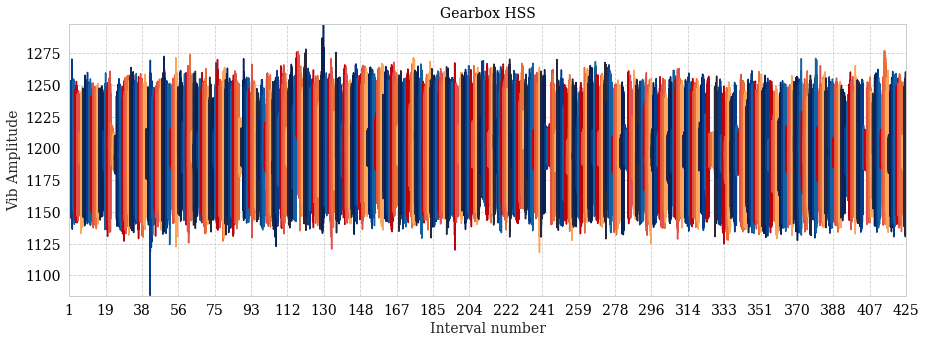

In [5]:
envelope.plot_vib_consecutive(vib_signal)

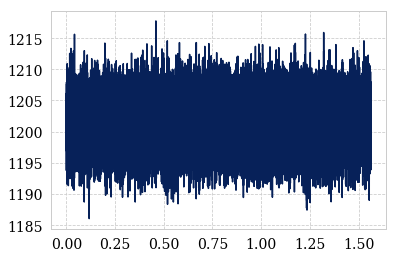

In [6]:
# One interval:
plt.plot(times[0][0:40000],vib_signal[0][0:40000])

In [7]:
low_cut = 2000
filtered_raw_vib = []
vib_signal_size = len(vib_signal)

for i, vib_sig in enumerate(vib_signal):
    flitered_vib_sig = filter_signals.do_high_pass_filter(vib_sig, low_cut)
    filtered_raw_vib.append(flitered_vib_sig)
    print(f'Filtered {i+1} / {vib_signal_size} signals', end='\r')
filtered_raw_vib = np.asarray(filtered_raw_vib)

### Plot FFT of raw and filtered raw for verification

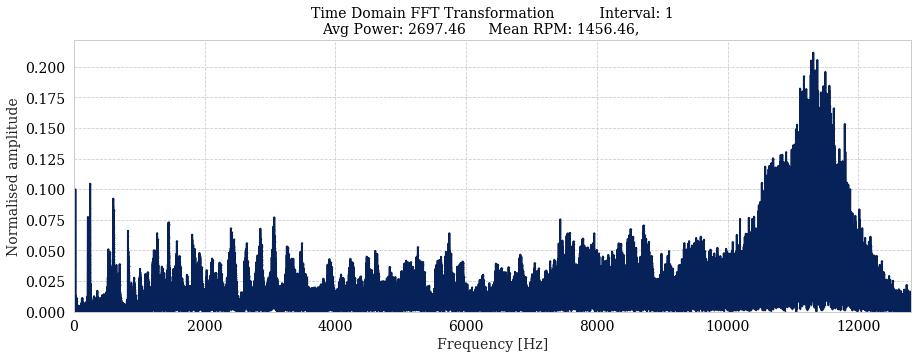

In [8]:
i = 1
fft.plot_fft(times[i], vib_signal[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

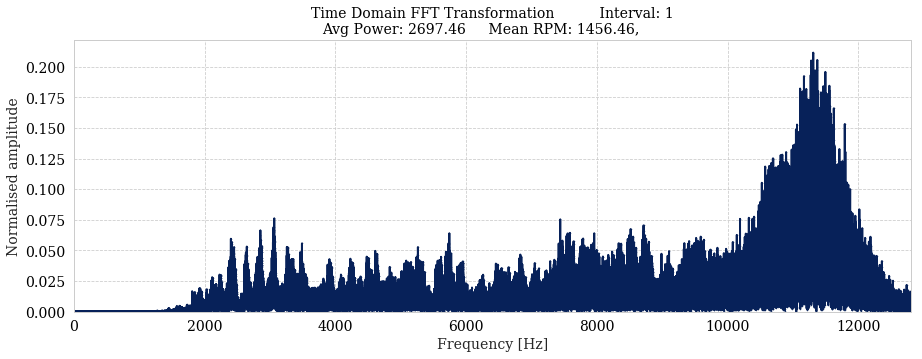

In [9]:
i = 1
fft.plot_fft(times[i], filtered_raw_vib[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

#### Save filtered, raw vibration signal to CSV

In [ ]:
'''
path = '/Volumes/OsvikExtra/signal_data/raw_filtered_2000Hz/gearbox/wt04/';
list_size = len(filtered_raw_vib)
for i, vib_sig in enumerate(filtered_raw_vib):
    np.savetxt(f'{path}filtered_raw_{i}.csv', vib_sig, delimiter=',')
    print(f'Saved {i+1} / {list_size} files', end='\r')
'''

## 2. Resampled signal

In [ ]:
time = times[0]
resampled_vib_signal = []
resampled_time_signal = []

for i, vib_sig in enumerate(vib_signal):
    resampled_round, resampled_y, resampled_time = resample_signals.do_resampling(time, 
                                                                                  vib_sig, 
                                                                                  peak_array[i],
                                                                                  number_of_resample_points=1500)
    resampled_time_signal.append(resampled_time)
    resampled_vib_signal.append(resampled_y)
    print(f'Resampled {i+1} / {vib_signal_size} signals', end='\r')

In [ ]:
i = 400
fft.plot_fft(resampled_time_signal[i], resampled_vib_signal[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

### 2.5 Filter out the first 2000 Hz

In [ ]:
low_cut = 2000
filtered_resampled_vib = []
resampled_vib_signal_size = len(resampled_vib_signal)

skip = 0
for i, vib_sig in enumerate(resampled_vib_signal):
    if len(vib_sig) < 100000:
        filtered_resampled_vib.append(vib_sig)
        skip +=1
        continue
    flitered_vib_sig = filter_signals.do_high_pass_filter(vib_sig, low_cut)
    filtered_resampled_vib.append(flitered_vib_sig)
    print(f'Filtered {i+1} / {resampled_vib_signal_size} resampled signals', end='\r')

In [ ]:
i = 0
fft.plot_fft(resampled_time_signal[i], filtered_resampled_vib[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

### Save filtered resampled vibration signal to CSV

In [ ]:
'''
path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/';
list_size = len(filtered_resampled_vib)
for i, vib_sig in enumerate(filtered_resampled_vib):
    np.savetxt(f'{path}filtered_resampled_{i}.csv', vib_sig, delimiter=',')
    print(f'Saved {i+1} / {list_size} files', end='\r')
'''

## 3. Filtered signal with optimal bandpass based on SK

In [11]:
# Read kurtogram data
fc_and_bw_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/fc_and_bw_data.csv';
frequencies_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/frequencies.csv';
file_names_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/file_name.txt';

fc_and_bw = pd.read_csv(fc_and_bw_path)
frequencies = pd.read_csv(frequencies_path)
file_names = pd.read_csv(file_names_path, header=None)

frequencies_numpy = np.asarray(frequencies).T
frequencies = pd.DataFrame(frequencies_numpy, columns= frequencies_numpy[0])
frequencies = frequencies.drop(frequencies.index[0]).reset_index(drop=True)
fc_and_bw

,File,Frequencies,Bandwidths
0,filtered_resampled_0.csv,10376.016144,4150.406458
1,filtered_resampled_1.csv,12771.655165,567.629118
2,filtered_resampled_10.csv,12720.156556,565.340291


In [13]:
kurt_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/kurtograms/';
kurt_file = f'{kurt_path}kgram_filtered_resampled_1.csv'
kurtogram = pd.read_csv(kurt_file, header=None)

In [14]:
def plot_kurtogram(kurtogram, frequencies):
    frequencies = np.asarray(frequencies)
    kurtogram_index = [0, 1, 1.6, 2, 2.6, 3, 3.6, 4, 4.6, 5, 5.6, 6, 6.6, 7, 7.6, 8]
    plt.figure(figsize=(10,8))
    color=['Blues_r', 'YlGnBu_r']
    chart = sns.heatmap(kurtogram, cmap=color[1])
    chart.set_xticklabels(frequencies, minor=False, rotation=45)
    chart.set_yticklabels(kurtogram_index, rotation=0)
    plt.show()

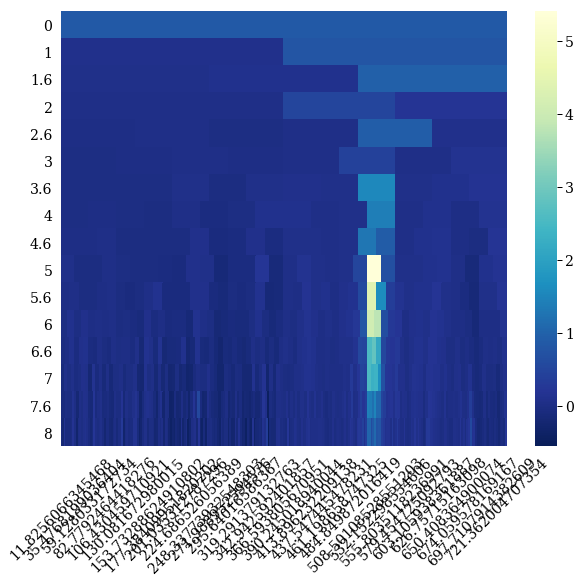

In [15]:
plot_kurtogram(kurtogram, frequencies['filtered_resampled_1.csv'])

## 4. Demodulasation using EEMD signals

In [ ]:
from PyEMD import EEMD
import numpy as np
import pylab as plt
# Define signal
S = vib_signal[0][0:10000]
t = times[0][0:10000]

# Assign EEMD to `eemd` variable
eemd = EEMD()
# Say we want detect extrema using parabolic method
emd = eemd.EMD
emd.extrema_detection="parabol"
# Execute EEMD on S
eIMFs = eemd.eemd(S, t)
nIMFs = eIMFs.shape[0]
# Plot results
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(t, S, 'r')


In [ ]:
envelope_emd.eemd('WT01',1,'gearbox',vib_signal[0][0:10000],times[0][0:10000],True)

## 5. Selecting IMF: Correlation coefficient

## 6. Envelope spectral analysis

## 7. Frequency study (fault characteristics), fault development